In [ ]:
view = 0
batch_sz = 4
epochs = 1
steps_per_epoch = 1000
validation_steps = 100

In [ ]:
!git clone https://github.com/GeorgeSeif/Semantic-Segmentation-Suite.git


Cloning into 'Semantic-Segmentation-Suite'...
remote: Enumerating objects: 3635, done.
remote: Total 3635 (delta 0), reused 0 (delta 0), pack-reused 3635
Receiving objects: 100% (3635/3635), 874.40 MiB | 23.86 MiB/s, done.
Resolving deltas: 100% (461/461), done.
Checking out files: 100% (1451/1451), done.


In [ ]:
import os

In [ ]:
from pathlib import Path
data_path = Path('Semantic-Segmentation-Suite/CamVid')

In [ ]:
print('Number of train frames: ' + str(len(os.listdir(data_path/'train'))))
print('Number of train labels: ' + str(len(os.listdir(data_path/'train_labels'))))
print('Number of val frames: ' + str(len(os.listdir(data_path/'val'))))
print('Number of val labels: ' + str(len(os.listdir(data_path/'val_labels'))))
print('Number of test frames: ' + str(len(os.listdir(data_path/'test'))))
print('Number of test labels: ' + str(len(os.listdir(data_path/'test_labels'))))
print('Total frames: ' + str(len(os.listdir(data_path/'train')) + len(os.listdir(data_path/'val')) + len(os.listdir(data_path/'test'))))

Number of train frames: 421
Number of train labels: 421
Number of val frames: 112
Number of val labels: 112
Number of test frames: 168
Number of test labels: 168
Total frames: 701


In [ ]:
import pandas as pd
classes = pd.read_csv(data_path / 'class_dict.csv', index_col =0)

In [ ]:
classes

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


In [ ]:
n_classes = len(classes)
n_classes

32

In [ ]:
# create a map from class name to color
cls2rgb = {cl:list(classes.loc[cl,:]) for cl in classes.index}

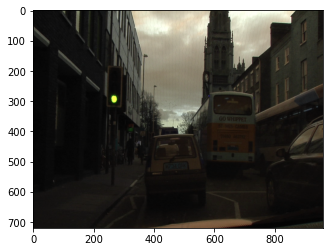

In [ ]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(str(data_path) + '/train/0001TP_006690.png')
plt.imshow(img)

In [ ]:
import numpy as np
mask = cv2.imread(str(data_path) + '/train_labels/0001TP_006690_L.png')
mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

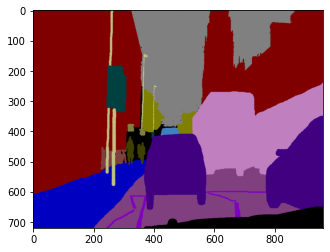

In [ ]:
plt.imshow(mask)

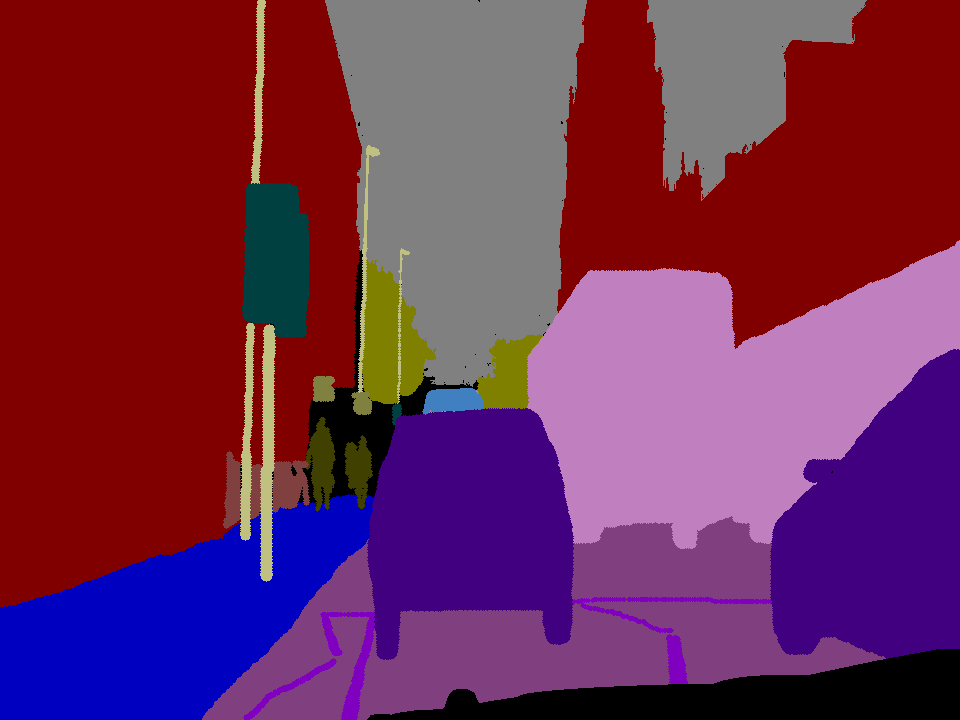

In [ ]:
from keras.preprocessing.image import load_img
mask = load_img(str(data_path) + '/train_labels/0001TP_006690_L.png')
mask

In [ ]:
mask = np.array(mask)# Now colors are the same as in the dict, since keras load_img uses RGB order.

In [ ]:
mask.shape

(720, 960, 3)

In [ ]:
def adjust_mask(mask, flat=False):

  semantic_map = []
  for colour in list(cls2rgb.values()):
    equality = np.equal(mask,colour)# 256x256x3 with True or False
    class_map = np.all(equality,axis=-1)# 256x256 If all True, then True, else False
    semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
  semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise. 
  if flat:
    semantic_map = np.reshape(semantic_map, (-1,256*256))  

  return np.float32(semantic_map) # convert to numbers

In [ ]:
new_mask = adjust_mask(mask)

In [ ]:
new_mask.shape

(720, 960, 32)

In [ ]:
idx2rgb = {idx:np.array(rgb) for idx,(cl,rgb) in enumerate(cls2rgb.items())}

In [ ]:
def map_class_to_rgb(p):

  return idx2rgb[p[0]]

rgb_mask = np.apply_along_axis(map_class_to_rgb,-1,np.expand_dims(np.argmax(new_mask,axis=-1),-1))  
# dy betkawenlak el sora tany fa betemshy 3la pixel pixel we teda5lha el function we bet2olha en da -1 ya3ny el slice elle rag3a mn el function tob2a metrateba badal array rgb tob2a channel b2a 
# el b fel a5er we el g ablaha we el r odam el -1 bete3kes el tarteb fa bet5aly el channel tetrateb sa7 we enta 3shan gowa el function 3amel p[0] fa betzawed dim using expand dims dy we betzwedo mn
# el a5er 3shan lma te3melo [0] ya5od elle fel awel 

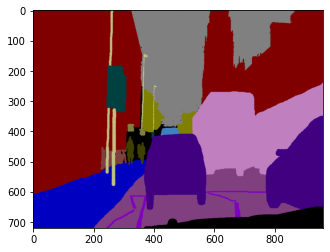

In [ ]:
plt.imshow(rgb_mask)

In [ ]:
import numpy as np 
import os
#import skimage.io as io
#import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(n_classes, pretrained_weights = None,input_size = (256,256,3), flat=False, ohe=True):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    x = UpSampling2D(size = (2,2))(drop5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(n_classes, (1,1), activation = 'softmax')(conv9)
    conv10 = Conv2D(n_classes, (1,1), padding='same')(conv9)
    if flat:
      output_layer = Reshape((256*256,n_classes))(conv10)
    else:
      output_layer = conv10
    output_layer = Activation('softmax')(output_layer)
    

    model = Model(inputs = inputs, outputs = output_layer)
    
    if ohe:
      model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    else:
      model.compile(optimizer = Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


In [ ]:
model = unet(n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def load_CAMVID(data_type='train', enc='ohe', shape='normal'):
  img_path = str(data_path) + '/' + data_type + '/'
  labels_path = str(data_path) + '/' + data_type + '_labels/'
  # without adding target_size=(256,256) in load_img we get Out of mem: 421x960x720x32x4bytes is around 34GB!
  x = np.array([np.array(load_img(str(img_path) + file, target_size=(256,256)))*1./255 for file in sorted(os.listdir(img_path))])
  if(enc=='ohe'):
    
    y = np.array([adjust_mask(np.array(load_img(str(labels_path) + file, target_size=(256,256)))) for file in sorted(os.listdir(labels_path))])
  elif(enc=='sparse_cat'):
    y = np.array([adjust_mask(np.array(load_img(str(labels_path) + file, target_size=(256,256)))) for file in sorted(os.listdir(labels_path))])
  if(shape == 'flat'):
    y = np.reshape(y.shape[0], y.shape[1]*y.shape[2])
    y = np.expand_dims(y, axis=-1)
  return x, y

In [ ]:
import time
start = time.time()
x_train, y_train = load_CAMVID(data_type='train')
#x_test, y_test = load_CAMVID(data_type='test')# Don't load test for RAM consumption
x_val, y_val = load_CAMVID(data_type='val')
end = time.time()
print('Time elapsed: ', end-start)

Time elapsed:  62.14749550819397


In [ ]:
print(x_train.shape)
print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(421, 256, 256, 3)
(421, 256, 256, 32)
(112, 256, 256, 3)
(112, 256, 256, 32)


In [ ]:
# model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
# model.fit(x=x_train, 
#               y=y_train,
#               validation_data=(x_val, y_val),
#               batch_size=batch_sz,# 32 gives OOM sometimes
#               epochs=epochs,
#               callbacks=[model_checkpoint])

In [ ]:
def visualize_seg(img, gt_mask, shape='normal', gt_mode='sparse'):
  plt.figure(1)

  # Img
  plt.subplot(311)
  plt.imshow(img)

  # Predict
  pred_mask = model.predict(np.expand_dims(img,0))
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[0]
  if shape == 'flat':
    pred_mask = np.reshape(pred_mask , (256,256)) # Reshape only if you use the flat model. O.w. you dont need

  rgb_mask = np.apply_along_axis(map_class_to_rgb, -1 , np.expand_dims(pred_mask , -1))

  # Prediction
  plt.subplot(312)
  plt.imshow(rgb_mask)

  # GT mask
  if gt_mode == 'ohe':
    gt_img_ohe = np.argmax(gt_mask, axis=-1)
    gt_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(gt_img_ohe, -1))              
  
  plt.subplot(313)
  plt.imshow((gt_mask).astype(np.uint8))  

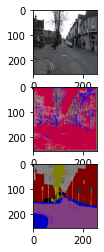

In [ ]:
visualize_seg(x_val[100], y_val[100], gt_mode='ohe')

In [ ]:
from tensorflow.keras.utils import Sequence
class CAMVID_Dataset(Sequence):


  def __init__(self, data_path, batch_size=4, dim=(256,256), n_classes=32, data_type='train', shape='normal'):
    self.images_dir = str(data_path) + '/' + data_type + '/'
    self.masks_dir = str(data_path) + '/' + data_type + '_labels/'
    assert len(os.listdir(self.images_dir)) == len(os.listdir(self.masks_dir))
    self.data_type = data_type
    self.shape = shape
    self.batch_size = batch_size
    self.dim = dim
    self.n = len(os.listdir(self.images_dir))
    self.n_batches = int(np.floor(self.n  / self.batch_size))
    self.indexes = np.arange(self.n)

  def __len__(self):
    return  self.n_batches

  def __getitem__(self, index):    
    X = np.empty((self.batch_size, *self.dim, 3))
    Y = np.zeros((self.batch_size, *self.dim, n_classes))
    indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]

    # Generate data
    for i , ID in enumerate(indexes):
      idx = ID

      file = sorted(os.listdir(self.images_dir))[idx]

      # Load image
      image = np.array(load_img(str(self.images_dir) + file , target_size=(256,256)))*1./255

      # Load mask
      file = sorted(os.listdir(self.masks_dir))[idx]
      mask = adjust_mask(np.array(load_img(str(self.masks_dir) + file, target_size=(256,256))))
    
      if(self.shape == 'flat'):
        mask = np.reshape(mask.shape[0], mask.shape[1]*mask.shape[2])
        mask = np.expand_dims(mask, axis=-1)        
      X[i,:] = image
      Y[i,:] = mask
      
    return X, Y

In [ ]:
train_gen = CAMVID_Dataset(str(data_path), batch_size=batch_sz, n_classes=n_classes, data_type='train')
valid_gen = CAMVID_Dataset(str(data_path), batch_size=batch_sz, n_classes=n_classes, data_type='val')

In [ ]:
x,y = next(enumerate(train_gen))[1]
print(x.shape)
print(y.shape)

(4, 256, 256, 3)
(4, 256, 256, 32)


In [ ]:
n_train_samples = len(os.listdir(str(data_path) + '/train/'))
n_train_samples

421

In [ ]:
model = unet(n_classes)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1,save_best_only=True)
model.fit_generator(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=n_train_samples,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


105/421 [======>.......................] - ETA: 4:32 - loss: 2.1449 - accuracy: 0.4126WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 421 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 1.67059, saving model to unet_camvid.hdf5
421/421 [==============================] - 122s 256ms/step - loss: 2.1449 - accuracy: 0.4126 - val_loss: 1.6706 - val_accuracy: 0.5772


In [ ]:
# Data generator
#https://keras.io/preprocessing/image/
# Data generator
#batch_sz = 4

from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments

# VI Note: use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
data_gen_args = dict(rescale=1./255)

# So our usage here is as data loader instead of loading everything in RAM, not data augmentation
mask_gen_args = dict()

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)
image_generator = image_datagen.flow_from_directory(data_path,
                                              class_mode=None,
                                              classes=['train'],
                                              seed=seed,
                                              batch_size=batch_sz,
                                              target_size=(256,256))

mask_generator = mask_datagen.flow_from_directory(data_path,
                                    classes=['train_labels'],
                                    class_mode=None,
                                    seed=seed,
                                    color_mode='rgb',
                                    batch_size=batch_sz,
                                    target_size=(256,256))

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)


val_image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['val'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256))

val_mask_generator = mask_datagen.flow_from_directory(
    data_path,
    classes=['val_labels'],
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256))

# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)

Found 421 images belonging to 1 classes.
Found 421 images belonging to 1 classes.
Found 112 images belonging to 1 classes.
Found 112 images belonging to 1 classes.


In [ ]:
def train_generator_fn():

    for (img,mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)  

In [ ]:
def val_generator_fn():

    for (img,mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)

In [ ]:
n_train_samples = len(os.listdir(str(data_path) + '/train/'))
n_train_samples

421

In [ ]:
model = unet(n_classes)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit_generator(train_generator_fn(),
                    validation_data=val_generator_fn(),
                    steps_per_epoch=n_train_samples,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=[model_checkpoint]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


421/421 [==============================] - ETA: 0s - loss: 1.2959 - accuracy: 0.6410
Epoch 00001: val_loss improved from inf to 0.88887, saving model to unet_camvid.hdf5
421/421 [==============================] - 419s 988ms/step - loss: 1.2959 - accuracy: 0.6410 - val_loss: 0.8889 - val_accuracy: 0.7588


In [ ]:
# Data generator
#batch_sz = 4
#https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments

# VI Note: use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255)

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
                    

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['train'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256))

mask_generator = mask_datagen.flow_from_directory(
    data_path,
    classes=['train_labels'],
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256))

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():
  for(img,mask) in train_generator:
    new_mask = adjust_mask(mask)
    yield (img,new_mask)
    
val_image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['val'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256))

val_mask_generator = mask_datagen.flow_from_directory(
    data_path,
    classes=['val_labels'],
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256))

# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)        
        
def val_generator_fn():

    for (img,mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)         


Found 421 images belonging to 1 classes.
Found 421 images belonging to 1 classes.
Found 112 images belonging to 1 classes.
Found 112 images belonging to 1 classes.


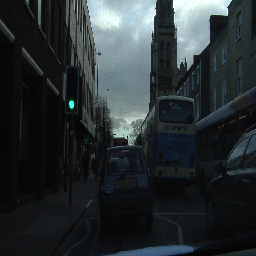

In [ ]:
img = load_img(str(data_path) + '/train/0001TP_006690.png', target_size=(256,256))
img

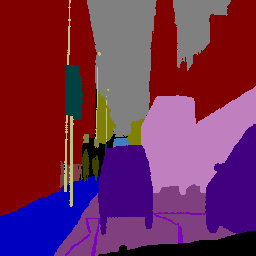

In [ ]:
mask = load_img(str(data_path) + '/train_labels/0001TP_006690_L.png', target_size=(256,256))
mask

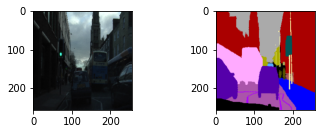

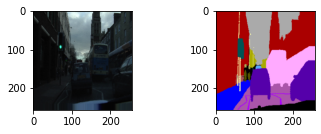

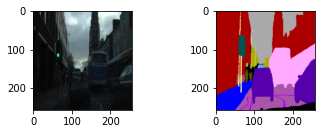

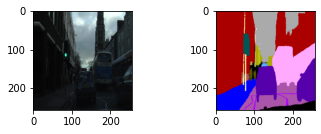

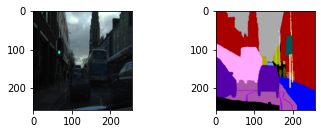

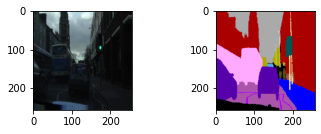

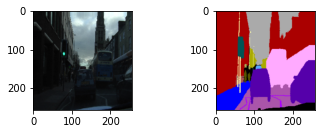

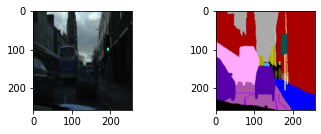

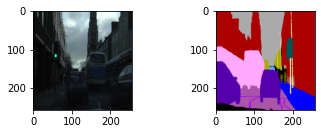

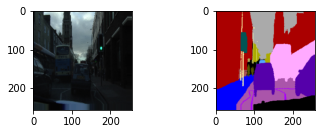

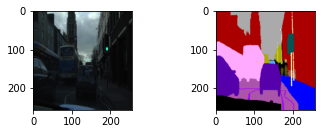

In [ ]:
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
from keras.preprocessing.image import array_to_img, img_to_array
i = 0
img = img_to_array(img)
mask = img_to_array(mask)
for aug_img, aug_mask in zip(image_datagen.flow(np.expand_dims(img, 0), batch_size=1), mask_datagen.flow(np.expand_dims(mask, 0), batch_size=1)):
    plt.figure(i)
    plt.subplot(221)
    imgplot = plt.imshow(array_to_img(aug_img[0]))
    plt.subplot(222)
    imgplot = plt.imshow(array_to_img(aug_mask[0]))
    i += 1
    if i > 10:
        break

plt.show()

In [ ]:
model = unet(n_classes)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit_generator(train_generator_fn(),
                    validation_data=val_generator_fn(),
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


1000/1000 [==============================] - ETA: 0s - loss: 5.3737 - accuracy: 0.4672
Epoch 00001: val_loss improved from inf to 1.69763, saving model to unet_camvid.hdf5
1000/1000 [==============================] - 933s 930ms/step - loss: 5.3737 - accuracy: 0.4672 - val_loss: 1.6976 - val_accuracy: 0.5254


In [ ]:
def load_raw_CAMVID(data_type='train', enc='ohe', shape='normal'):
  img_path = str(data_path) + '/' + data_type + '/'
  labels_path = str(data_path) + '/' + data_type + '_labels/'
  # without adding target_size=(256,256) in load_img we get Out of mem: 421x960x720x32x4bytes is around 34GB!
  x = np.array([np.array(load_img(str(img_path) + file, target_size=(256,256)))*1./255 for file in sorted(os.listdir(img_path))])
  if(enc=='ohe'):
    
    y = np.array([np.array(load_img(str(labels_path) + file, target_size=(256,256))) for file in sorted(os.listdir(labels_path))])
  elif(enc=='sparse_cat'):
    y = np.array([np.array(load_img(str(labels_path) + file, target_size=(256,256))) for file in sorted(os.listdir(labels_path))])
  if(shape == 'flat'):
    y = np.reshape(y.shape[0], y.shape[1]*y.shape[2])
    y = np.expand_dims(y, axis=-1)
  return x, y

In [ ]:
import time
start = time.time()
x_train, y_train = load_raw_CAMVID(data_type='train')
#x_test, y_test = load_raw_CAMVID(data_type='test')# Don't load test for RAM consumption
x_val, y_val = load_raw_CAMVID(data_type='val')
end = time.time()
print('Time elapsed: ', end-start)

print(x_train.shape)
print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

Time elapsed:  23.15549612045288
(421, 256, 256, 3)
(421, 256, 256, 3)
(112, 256, 256, 3)
(112, 256, 256, 3)


In [ ]:
# Data generator
#batch_sz = 4
#https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments

# VI Note: use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
                    #rescale=1./255)# Data is already scaled when loaded

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
                    #preprocessing_function=adjust_mask)# This is not possible since the preprocessing_function can only return the same shape as image

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow(
    x_train,
    seed=seed,
    batch_size=batch_sz)

mask_generator = mask_datagen.flow( 
    y_train,
    seed=seed,
    batch_size=batch_sz)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():

    for (img,mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)  
        
val_image_generator = image_datagen.flow(
    x_val,
    seed=seed,
    batch_size=batch_sz)

val_mask_generator = mask_datagen.flow(
    y_val,
    seed=seed,
    batch_size=batch_sz)

# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)        
        
def val_generator_fn():

    for (img,mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)         


In [ ]:
model = unet(n_classes)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit_generator(train_generator_fn(),
                    validation_data=val_generator_fn(),
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


1000/1000 [==============================] - ETA: 0s - loss: 7.6627 - accuracy: 0.3847
Epoch 00001: val_loss improved from inf to 2.50644, saving model to unet_camvid.hdf5
1000/1000 [==============================] - 910s 909ms/step - loss: 7.6627 - accuracy: 0.3847 - val_loss: 2.5064 - val_accuracy: 0.2834


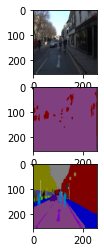

In [ ]:
img = next(val_image_generator)[0]
gt_img = next(val_mask_generator)[0]
visualize_seg(img, gt_img, gt_mode='sparse')